# Summary of this Code

Submission Score - 87% AUC Score
Light GBM Without Normalization 
Bayesian Hyper parameter optimization

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle

In [ ]:
!pip install scikit-plot

In [ ]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c santander-customer-transaction-prediction

 94% 234M/250M [00:01<00:00, 193MB/s]
100% 250M/250M [00:01<00:00, 137MB/s]


In [ ]:
# Installing the most recent version of skopt directly from Github
!pip install git+https://github.com/scikit-optimize/scikit-optimize.git

  Cloning https://github.com/scikit-optimize/scikit-optimize.git to /tmp/pip-req-build-hx9wa5te
  Running command git clone -q https://github.com/scikit-optimize/scikit-optimize.git /tmp/pip-req-build-hx9wa5te
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Using cached pyaml-21.10.1-py2.py3-none-any.whl (24 kB)
  Created wheel for scikit-optimize: filename=scikit_optimize-0.9.0-py2.py3-none-any.whl size=100268 sha256=a9b0fd3b8e9d31bd0b905a2721e98bdf74de6ba8cc027cdb0ae9e4165b09d161
  Stored in directory: /tmp/pip-ephem-wheel-cache-x5i60sf0/wheels/d6/9e/e3/8818f5597f06caa60393811f8aa57eb87b8565d772046d1b72
Successfully built scikit-optimize


In [ ]:
# Plotting Libs
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
import zipfile
import os

import seaborn as sns
from matplotlib.colors import ListedColormap

# Calculation and math lib
import math
from scipy import stats
import pandas as pd
import numpy as np

#Classifiers used

from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier

# Evaluation Metrics and Optimizers
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV, RandomizedSearchCV, KFold,StratifiedKFold
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report,roc_auc_score,mean_absolute_error

# Bayesian Optimization
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, DeltaYStopper
from skopt.space import Real, Categorical, Integer

# Unzipping the Dataset

In [ ]:
# Unzipping the overall dataset into train and test
!unzip -q /content/santander-customer-transaction-prediction.zip

! rm /content/santander-customer-transaction-prediction.zip
! rm /content/sample_submission.csv	

! ls /content

kaggle.json  sample_data  test.csv  train.csv


# Reading the Data & I/P Exploration

In [ ]:
# Reading the data and just printing 2 rows of both test and train to see if they were read
training_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
print(training_data.head(2))
print(test_data.head(2))

   ID_code  target    var_0   var_1    var_2  var_3    var_4   var_5   var_6  \
0  train_0       0   8.9255 -6.7863  11.9081  5.093  11.4607 -9.2834  5.1187   
1  train_1       0  11.5006 -4.1473  13.8588  5.389  12.3622  7.0433  5.6208   

     var_7  ...  var_190  var_191  var_192  var_193  var_194  var_195  \
0  18.6266  ...   4.4354   3.9642   3.1364   1.6910  18.5227  -2.3978   
1  16.5338  ...   7.6421   7.7214   2.5837  10.9516  15.4305   2.0339   

   var_196  var_197  var_198  var_199  
0   7.8784   8.5635  12.7803  -1.0914  
1   8.1267   8.7889  18.3560   1.9518  

[2 rows x 202 columns]
  ID_code    var_0   var_1    var_2   var_3    var_4   var_5   var_6    var_7  \
0  test_0  11.0656  7.7798  12.9536  9.4292  11.4327 -2.3805  5.8493  18.2675   
1  test_1   8.5304  1.2543  11.3047  5.1858   9.1974 -4.0117  6.0196  18.6316   

    var_8  ...  var_190  var_191  var_192  var_193  var_194  var_195  var_196  \
0  2.1337  ...  -2.1556  11.8495  -1.4300   2.4508  13.7112   2.4669  

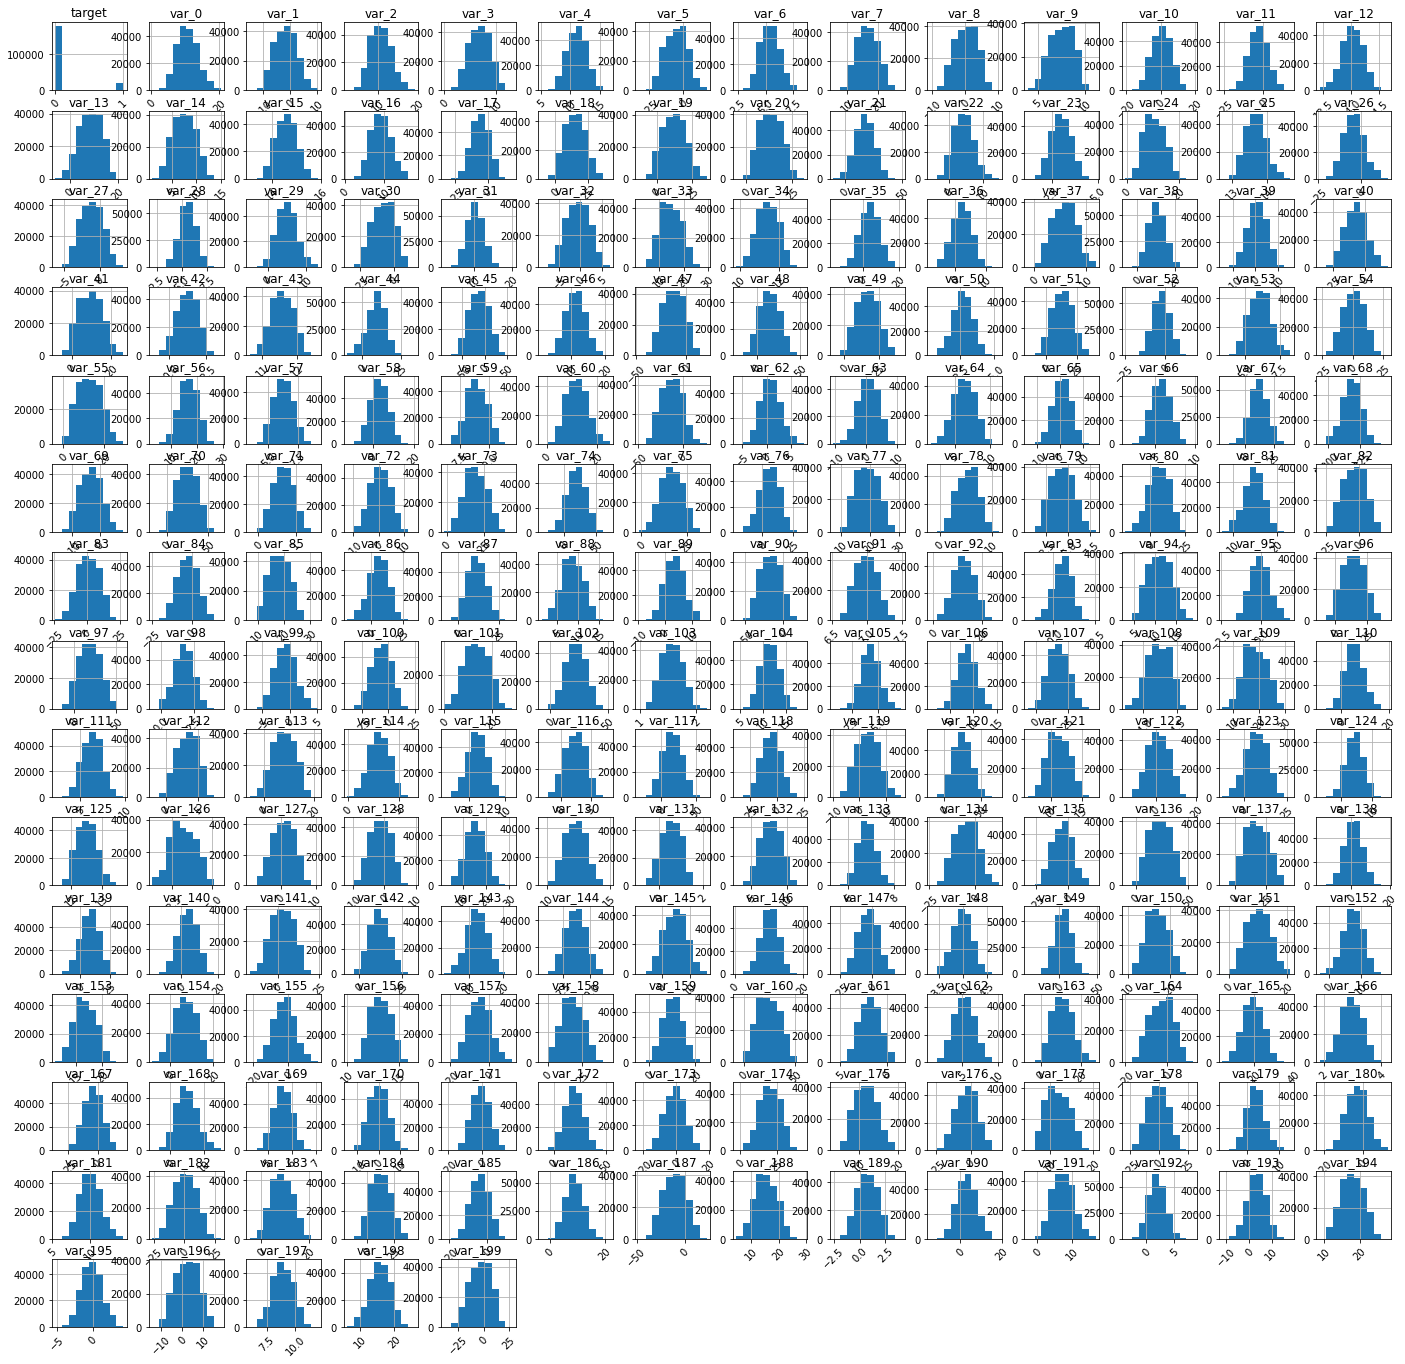

In [ ]:
training_data.hist(figsize=(24,24), xrot=45)
plt.show()

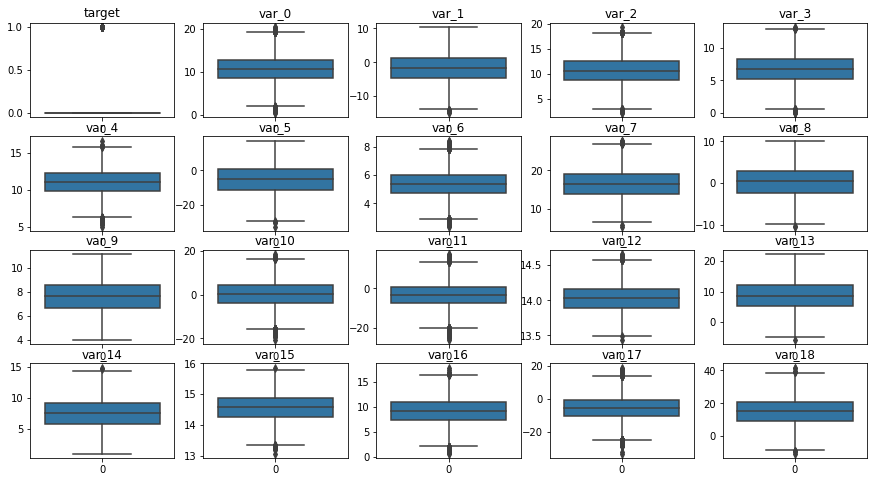

In [ ]:
plt.figure(figsize = (15,8))
for i in range(1,21):
    plt.subplot( 4, 5, i)
    sns.boxplot(data = training_data.iloc[:, i])
    plt.title(training_data.columns[i])
    

## Outlier Treatment

In [ ]:
outlier_treated_data = training_data.drop('ID_code',axis = 1)
outlier_treated_data = outlier_treated_data[(np.abs(stats.zscore(outlier_treated_data)) < 6).all(axis = 1)]
outlier_treated_data.shape

related = outlier_treated_data.corr()['target'].sort_values(ascending = False)
related

target     1.000000
var_6      0.066731
var_110    0.064275
var_53     0.063399
var_26     0.062422
             ...   
var_76    -0.061917
var_146   -0.063644
var_12    -0.069489
var_139   -0.074080
var_81    -0.080917
Name: target, Length: 201, dtype: float64

### Sampling a little bit of data to check if the code runs - Will be commented out if the model works

In [ ]:
# Data Engineering on Training Data - Adding a column to show the unique value counts if each coulms

def transform(df,training_data):
    df1=training_data.copy()
    col = df.columns
    df[col[0]+'_counts']=df1.groupby(col[0])[col[1]].transform('count')
    df[col[0]+'_unique']=df[col[0]+'_counts'].apply(lambda x : 1 if x==1 else 0 )
    df[col[0]+'_unique2']=df[col[0]+'_counts'].apply(lambda x : 1 if x==2 else 0 )
#     df[col[0]+'_encoding']=df1.groupby(col[0])['target'].transform('mean')
#     df[col[0]+'_encoding']=df[[col[0]+'_counts',col[0]+'_encoding']].apply(lambda x : x[col[0]+'_encoding'] if x[col[0]+'_counts']>=3 else 0 ,axis =1)
    for k in col[1:]:
        if k!= 'target':
            df[k+"_counts"] = df1.groupby(k)[col[0]].transform('count')
            df[k+'_unique']=df[k+'_counts'].apply(lambda x : 1 if x==1 else 0 )
            df[k+'_unique2']=df[k+'_counts'].apply(lambda x : 1 if x==2 else 0 )
#             df[k+'_encoding']=df1.groupby(k)['target'].transform('mean')
#             df[k+'_encoding']=df[[k+'_counts',k+'_encoding']].apply(lambda x : x[k+'_encoding'] if x[k+'_counts']>=3 else 0 ,axis =1)
    return df.fillna(0)

x_data = outlier_treated_data[outlier_treated_data.columns[1:]]
x_data= transform(x_data.copy(),outlier_treated_data)
x_train, x_val, y_train, y_val = train_test_split(x_data, outlier_treated_data['target'], test_size=0.20, random_state=42)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a d

# Light GBM Base Models - N0 sclaing

In [ ]:
# LightGBM Classifier
# Unscaled / Unweighted classifier # Unoptimized
model = LGBMClassifier()
model.fit(x_train, y_train)

y_pred = model.predict(x_val)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_val, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# Performance on the unweighed model is not good enough for the minority class, so have to weigh the model

class_names = outlier_treated_data['target'].unique()

# Calculating the confusion matrix, accuracy, error, f-score, recall, precision
matrix = classification_report(y_pred,y_val,labels=class_names)
print('Classification report of test data on unoptimized LightGBM: \n',matrix)



# Test Data Prepearation

test_names = test_data['ID_code']
test_values = test_data.drop('ID_code',axis = 1)
test_values = transform(test_values,training_data)
test_columns = test_values.columns

# Scaling the values
#test_values = pd.DataFrame(robust_scaler.fit_transform(test_values), columns = test_columns)

# Predicting the test values
test_predictions = model.predict_proba(test_values)

# Conversion to kaggle submission format
submission = pd.DataFrame({'ID_code':test_names,'target':test_predictions[:,1]})
submission.to_csv('Submission_Bay_opt_lgbm.csv', index = False)
from google.colab import files
files.download('Submission_Bay_opt_lgbm.csv')

Accuracy: 90.72%
Classification report of test data on unoptimized LightGBM: 
               precision    recall  f1-score   support

           0       1.00      0.91      0.95     39513
           1       0.11      0.90      0.19       487

    accuracy                           0.91     40000
   macro avg       0.55      0.90      0.57     40000
weighted avg       0.99      0.91      0.94     40000



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a d

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

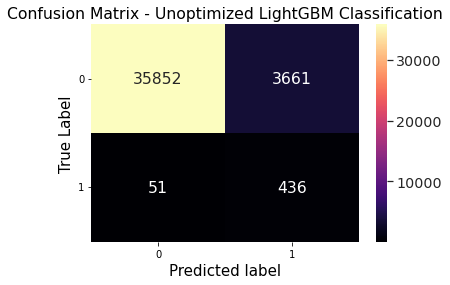

<Figure size 720x504 with 0 Axes>

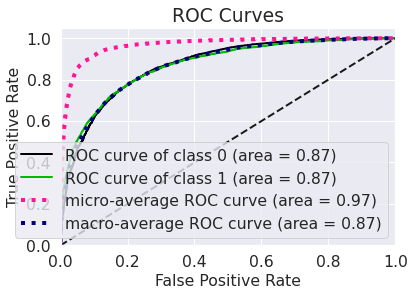

<Figure size 3240x2304 with 0 Axes>

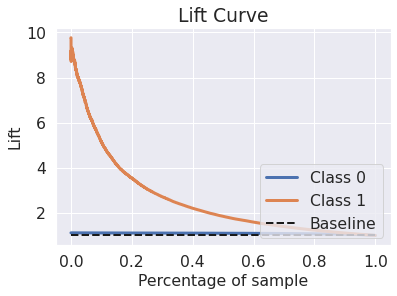

In [ ]:
# Calculating the confusion matrix, accuracy, error, f-score, recall, precision
confusion_matrix = metrics.confusion_matrix(y_pred,y_val)
#turn this into a dataframe
matrix_df = pd.DataFrame(confusion_matrix)

#plot the result
ax = plt.axes()
sns.set(font_scale=1.3)
plt.figure(figsize=(10,7))
sns.heatmap(matrix_df, annot=True, fmt="g", ax=ax, cmap="magma")
#set axis titles
ax.set_title('Confusion Matrix - Unoptimized LightGBM Classification')
ax.set_xlabel("Predicted label", fontsize =15)
ax.set_xticklabels(class_names)
ax.set_ylabel("True Label", fontsize=15)
ax.set_yticklabels(class_names, rotation = 0)
plt.show()

# Implementing ROC Curves
y_probas = model.predict_proba(x_val)
import scikitplot as skplt
skplt.metrics.plot_roc(y_val,y_probas)
plt.figure(figsize=(45, 32))
plt.show()

# Implementing Lift Curves
skplt.metrics.plot_lift_curve(y_val,y_probas)
plt.show()

# XGBoost Model

In [ ]:
# LightGBM Classifier
# Unscaled / Unweighted classifier # Unoptimized
model = XGBClassifier()
model.fit(x_train, y_train)

y_pred = model.predict(x_val)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_val, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# Performance on the unweighed model is not good enough for the minority class, so have to weigh the model

class_names = outlier_treated_data['target'].unique()

# Calculating the confusion matrix, accuracy, error, f-score, recall, precision
matrix = classification_report(y_pred,y_val,labels=class_names)
print('Classification report of test data on unoptimized Model: \n',matrix)



# Test Data Prepearation

test_names = test_data['ID_code']
test_values = test_data.drop('ID_code',axis = 1)
test_values = transform(test_values,training_data)
test_columns = test_values.columns

# Scaling the values
#test_values = pd.DataFrame(robust_scaler.fit_transform(test_values), columns = test_columns)

# Predicting the test values
test_predictions = model.predict_proba(test_values)

# Conversion to kaggle submission format
submission = pd.DataFrame({'ID_code':test_names,'target':test_predictions[:,1]})
submission.to_csv('Submission_Bay_opt_lgbm.csv', index = False)
from google.colab import files
files.download('Submission_Bay_opt_lgbm.csv')

Accuracy: 89.92%
Classification report of test data on unoptimized Model: 
               precision    recall  f1-score   support

           0       1.00      0.90      0.95     39922
           1       0.02      0.91      0.03        78

    accuracy                           0.90     40000
   macro avg       0.51      0.90      0.49     40000
weighted avg       1.00      0.90      0.95     40000



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a d

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

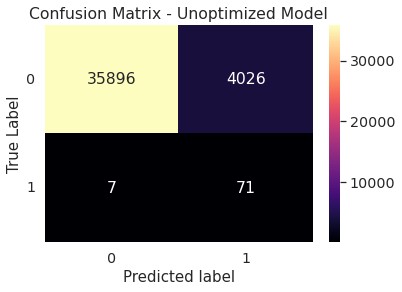

<Figure size 720x504 with 0 Axes>

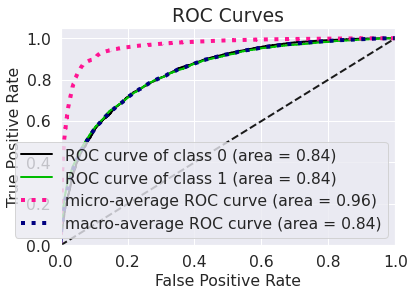

<Figure size 3240x2304 with 0 Axes>

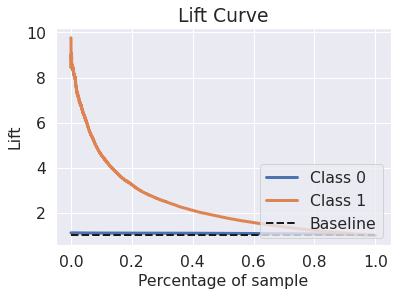

In [ ]:
# Calculating the confusion matrix, accuracy, error, f-score, recall, precision
confusion_matrix = metrics.confusion_matrix(y_pred,y_val)
#turn this into a dataframe
matrix_df = pd.DataFrame(confusion_matrix)

#plot the result
ax = plt.axes()
sns.set(font_scale=1.3)
plt.figure(figsize=(10,7))
sns.heatmap(matrix_df, annot=True, fmt="g", ax=ax, cmap="magma")
#set axis titles
ax.set_title('Confusion Matrix - Unoptimized Model')
ax.set_xlabel("Predicted label", fontsize =15)
ax.set_xticklabels(class_names)
ax.set_ylabel("True Label", fontsize=15)
ax.set_yticklabels(class_names, rotation = 0)
plt.show()

# Implementing ROC Curves
y_probas = model.predict_proba(x_val)
import scikitplot as skplt
skplt.metrics.plot_roc(y_val,y_probas)
plt.figure(figsize=(45, 32))
plt.show()

# Implementing Lift Curves
skplt.metrics.plot_lift_curve(y_val,y_probas)
plt.show()

Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(x_train, y_train)

y_pred = model.predict(x_val)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_val, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# Performance on the unweighed model is not good enough for the minority class, so have to weigh the model

class_names = outlier_treated_data['target'].unique()

# Calculating the confusion matrix, accuracy, error, f-score, recall, precision
matrix = classification_report(y_pred,y_val,labels=class_names)
print('Classification report of test data on unoptimized Model: \n',matrix)



# Test Data Prepearation

test_names = test_data['ID_code']
test_values = test_data.drop('ID_code',axis = 1)
test_values = transform(test_values,training_data)
test_columns = test_values.columns

# Scaling the values
#test_values = pd.DataFrame(robust_scaler.fit_transform(test_values), columns = test_columns)

# Predicting the test values
test_predictions = model.predict_proba(test_values)

# Conversion to kaggle submission format
submission = pd.DataFrame({'ID_code':test_names,'target':test_predictions[:,1]})
submission.to_csv('Submission_Bay_opt_lgbm.csv', index = False)
from google.colab import files
files.download('Submission_Bay_opt_lgbm.csv')

Accuracy: 89.76%
Classification report of test data on unoptimized Model: 
               precision    recall  f1-score   support

           0       1.00      0.90      0.95     40000
           1       0.00      0.00      0.00         0

    accuracy                           0.90     40000
   macro avg       0.50      0.45      0.47     40000
weighted avg       1.00      0.90      0.95     40000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: PerformanceWarning: DataFr

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

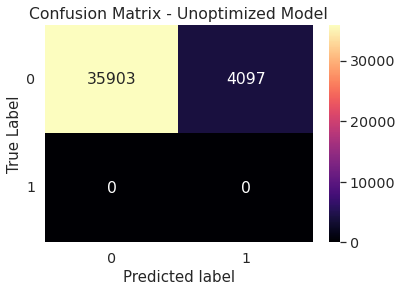

<Figure size 720x504 with 0 Axes>

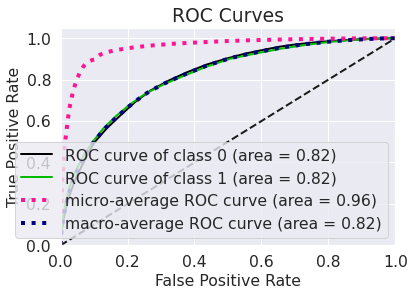

<Figure size 3240x2304 with 0 Axes>

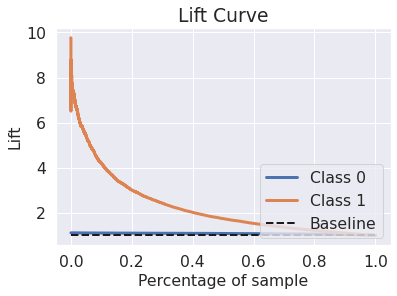

In [ ]:
# Calculating the confusion matrix, accuracy, error, f-score, recall, precision
confusion_matrix = metrics.confusion_matrix(y_pred,y_val)
#turn this into a dataframe
matrix_df = pd.DataFrame(confusion_matrix)

#plot the result
ax = plt.axes()
sns.set(font_scale=1.3)
plt.figure(figsize=(10,7))
sns.heatmap(matrix_df, annot=True, fmt="g", ax=ax, cmap="magma")
#set axis titles
ax.set_title('Confusion Matrix - Unoptimized Model')
ax.set_xlabel("Predicted label", fontsize =15)
ax.set_xticklabels(class_names)
ax.set_ylabel("True Label", fontsize=15)
ax.set_yticklabels(class_names, rotation = 0)
plt.show()

# Implementing ROC Curves
y_probas = model.predict_proba(x_val)
import scikitplot as skplt
skplt.metrics.plot_roc(y_val,y_probas)
plt.figure(figsize=(45, 32))
plt.show()

# Implementing Lift Curves
skplt.metrics.plot_lift_curve(y_val,y_probas)
plt.show()

Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(x_train, y_train)

y_pred = model.predict(x_val)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_val, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# Performance on the unweighed model is not good enough for the minority class, so have to weigh the model

class_names = outlier_treated_data['target'].unique()

# Calculating the confusion matrix, accuracy, error, f-score, recall, precision
matrix = classification_report(y_pred,y_val,labels=class_names)
print('Classification report of test data on unoptimized Model: \n',matrix)



# Test Data Prepearation

test_names = test_data['ID_code']
test_values = test_data.drop('ID_code',axis = 1)
test_values = transform(test_values,training_data)
test_columns = test_values.columns

# Scaling the values
#test_values = pd.DataFrame(robust_scaler.fit_transform(test_values), columns = test_columns)

# Predicting the test values
test_predictions = model.predict_proba(test_values)

# Conversion to kaggle submission format
submission = pd.DataFrame({'ID_code':test_names,'target':test_predictions[:,1]})
submission.to_csv('Submission_Bay_opt_lgbm.csv', index = False)
from google.colab import files
files.download('Submission_Bay_opt_lgbm.csv')

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Accuracy: 90.72%
Classification report of test data on unoptimized Model: 
               precision    recall  f1-score   support

           0       0.99      0.92      0.95     38719
           1       0.20      0.65      0.31      1281

    accuracy                           0.91     40000
   macro avg       0.60      0.78      0.63     40000
weighted avg       0.96      0.91      0.93     40000



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a d

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

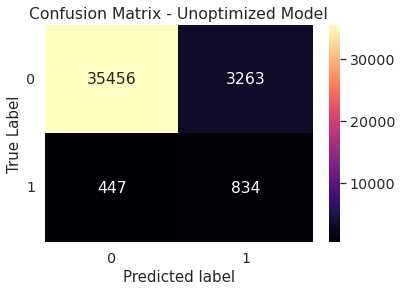

<Figure size 720x504 with 0 Axes>

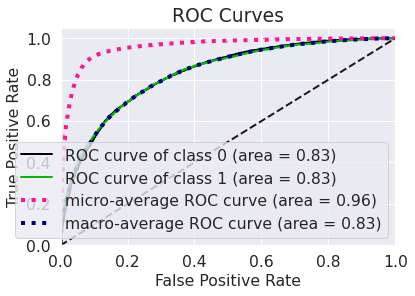

<Figure size 3240x2304 with 0 Axes>

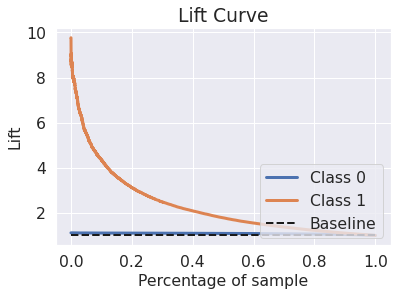

In [ ]:
# Calculating the confusion matrix, accuracy, error, f-score, recall, precision
confusion_matrix = metrics.confusion_matrix(y_pred,y_val)
#turn this into a dataframe
matrix_df = pd.DataFrame(confusion_matrix)

#plot the result
ax = plt.axes()
sns.set(font_scale=1.3)
plt.figure(figsize=(10,7))
sns.heatmap(matrix_df, annot=True, fmt="g", ax=ax, cmap="magma")
#set axis titles
ax.set_title('Confusion Matrix - Unoptimized Model')
ax.set_xlabel("Predicted label", fontsize =15)
ax.set_xticklabels(class_names)
ax.set_ylabel("True Label", fontsize=15)
ax.set_yticklabels(class_names, rotation = 0)
plt.show()

# Implementing ROC Curves
y_probas = model.predict_proba(x_val)
import scikitplot as skplt
skplt.metrics.plot_roc(y_val,y_probas)
plt.figure(figsize=(45, 32))
plt.show()

# Implementing Lift Curves
skplt.metrics.plot_lift_curve(y_val,y_probas)
plt.show()

In [28]:
# Data Engineering on Training Data - Adding a column to show the unique value counts if each coulms

def transform(df,training_data):
    df1=training_data.copy()
    df2 = test_data.copy()
    col = df.columns
    print(df1.columns)
    df[col[0]+'_counts']=df1.groupby(col[0])[col[1]].transform('count')
    df[col[0]+'_test_counts']=df2.groupby(col[0])[col[1]].transform('count')
#     df[col[0]+'_tot_counts']=df[col[0]+'_test_counts']+df[col[0]+'_counts']
    df[col[0]+'_unique']=df[col[0]+'_counts'].apply(lambda x : 1 if x==1 else 0 )
    df[col[0]+'_unique2']=df[col[0]+'_counts'].apply(lambda x : 1 if x>2 else 0 )
#     df[col[0]+'_encoding']=df1.groupby(col[0])['target'].transform('sum')/df1['target'].sum()
#     df[col[0]+'_encoding']=df[[col[0]+'_counts',col[0]+'_encoding']].apply(lambda x : x[col[0]+'_encoding'] if x[col[0]+'_counts']>=3 else 0 ,axis =1)
    for k in col[1:]:
        if k!= 'target':
            df[k+"_counts"] = df1.groupby(k)[col[0]].transform('count')
            df[k+'_test_counts']=df2.groupby(k)[col[0]].transform('count')
#             df[k+'_tot_counts']=df[k+'_test_counts']+df[k+'_counts']
            df[k+'_unique']=df[k+'_counts'].apply(lambda x : 1 if x==1 else 0 )
            df[k+'_unique2']=df[k+'_counts'].apply(lambda x : 1 if x>2 else 0 )
#             df[k+'_encoding']=df1.groupby(k)['target'].transform('sum')/df1['target'].sum()
#             df[k+'_encoding']=df[[k+'_counts',k+'_encoding']].apply(lambda x : x[k+'_encoding'] if x[k+'_counts']>=3 else 0 ,axis =1)
    return df.fillna(0)

x_data = outlier_treated_data[outlier_treated_data.columns[1:]]
x_data= transform(x_data.copy(),outlier_treated_data)
x_train, x_val, y_train, y_val = train_test_split(x_data, outlier_treated_data['target'], test_size=0.20, random_state=42)


#outlier_treated_data = transform(outlier_treated_data)
#outlier_treated_data.head(2)
#outlier_treated_data = outlier_treated_data.drop('target_counts',axis = 1)
def transform_2(df,training_data,features):
    df1=training_data.copy()
    df2 = test_data.copy()
    col = df.columns
#     df[col[0]+'_encoding']=df1.groupby(col[0])['target'].transform('sum')/df1['target'].sum()
#     df[col[0]+'_encoding']=df[[col[0]+'_counts',col[0]+'_encoding']].apply(lambda x : x[col[0]+'_encoding'] if x[col[0]+'_counts']>=3 else 0 ,axis =1)
    for k in features:
        if k!= 'target':
            df[k+"_counts"] = df1.groupby(k)[col[0]].transform('count')
            df[k+'_test_counts']=df2.groupby(k)[col[0]].transform('count')
#             df[k+'_tot_counts']=df[k+'_test_counts']+df[k+'_counts']
            df[k+'_unique']=df[k+'_counts'].apply(lambda x : 1 if x==1 else 0 )
            df[k+'_unique2']=df[k+'_counts'].apply(lambda x : 1 if x>2 else 0 )
#             df[k+'_encoding']=df1.groupby(k)['target'].transform('sum')/df1['target'].sum()
#             df[k+'_encoding']=df[[k+'_counts',k+'_encoding']].apply(lambda x : x[k+'_encoding'] if x[k+'_counts']>=3 else 0 ,axis =1)
    return df.fillna(0)

Index(['target', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6',
       'var_7', 'var_8',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=201)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, u




Hyper parameter tuning lightgbm



In [ ]:
# Optimized
x_data = outlier_treated_data[outlier_treated_data.columns[1:]]
x_data= transform(x_data.copy(),outlier_treated_data)
x_train, x_val, y_train, y_val = train_test_split(x_data, outlier_treated_data['target'], test_size=0.20, random_state=42)

bayes_cv_tuner = BayesSearchCV(estimator = LGBMClassifier(
                            validate_parameters = True,
                           
                                early_stopping = 400,
                                n_jobs = -1,
                                objective = 'binary',
                                eval_metric = 'auc',
                                metric = 'auc'),
                                
    
    search_spaces = {
        'boosting_type' : Categorical(['gbdt','dart','goss']),
        'num_leaves': (2, 20, 'uniform'),
        'max_depth' : (1, 50, 'uniform'),
        'learning_rate' :(0.0001, 1.0000, 'uniform'),
        'n_estimators' : (80, 500, 'uniform'),
        # 'scale_pos_weight': (0.2, 500, 'uniform'),
        'min_split_gain' :(0.0001, 0.2, 'uniform'),
        'min_child_weight': (0.001, 0.5, 'uniform'),
        'min_child_samples' :(10, 30, 'uniform'),
        'reg_alpha': (0.000, 2.5000, 'uniform'),
        'reg_lambda': (0.000, 5.000, 'uniform'),

        'tree_learner' : Categorical(['serial','feature','data','voting']),
    },    
    scoring = 'roc_auc',
    cv = StratifiedKFold(
        n_splits=3,
        shuffle=True,
        random_state=42),
    n_jobs = 3,
    n_iter = 20,   
    verbose = 500,
    refit = True,
    random_state = 786)
result = bayes_cv_tuner.fit(x_train, y_train, eval_set = (x_val, y_val))

Index(['target', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6',
       'var_7', 'var_8',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=201)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, u

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


In [ ]:
# LightGBM Classifier
# Unscaled / Unweighted classifier # Unoptimized
model = LGBMClassifier(  learning_rate=0.42499796546303836,
               max_depth=4, min_split_gain=0.6453337367285045,
               n_estimators=292, num_leaves=4, objective='binary',
               reg_alpha=0.500735665426298, reg_lambda=3.308777441932352,
               scale_pos_weight=108, silent=1, tree_learner='serial',
               validate_parameters=True)
model.fit(x_train, y_train)

y_pred = model.predict(x_val)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_val, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# Performance on the unweighed model is not good enough for the minority class, so have to weigh the model

class_names = outlier_treated_data['target'].unique()

# Calculating the confusion matrix, accuracy, error, f-score, recall, precision
matrix = classification_report(y_pred,y_val,labels=class_names)
print('Classification report of test data on unoptimized logistic regression: \n',matrix)

Stacking lightgbm randomforest logistic regressionn

In [26]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

estimators = [     ('lgbm', lgb.LGBMClassifier(  boosting_type='dart',  
               learning_rate=0.5106841277225264, max_depth=16, metric='auc',
               min_child_samples=25, min_child_weight=0.39526067551556837,
               min_split_gain=0.11718159124082063, n_estimators=200,
               num_leaves=5, objective='binary', reg_alpha=2.2129510625460744,
               reg_lambda=1.1553003144841483, tree_learner='serial',n_jobs =-1))
              , RandomForestClassifier()
       ]
clf = StackingClassifier(     estimators=estimators, final_estimator=LogisticRegression() ,n_jobs =-1,passthrough =True)
clf.fit(x_train, y_train)

y_pred = clf.predict(x_val)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_val, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# Performance on the unweighed model is not good enough for the minority class, so have to weigh the model

class_names = outlier_treated_data['target'].unique()

# Calculating the confusion matrix, accuracy, error, f-score, recall, precision
matrix = classification_report(y_pred,y_val,labels=class_names)
print('Classification report of test data on unoptimized logistic regression: \n',matrix)
print(roc_auc_score(y_val,clf.predict_proba(x_val)[:,1]))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Accuracy: 90.73%
Classification report of test data on unoptimized logistic regression: 
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     38850
           1       0.19      0.67      0.29      1150

    accuracy                           0.91     40000
   macro avg       0.59      0.79      0.62     40000
weighted avg       0.97      0.91      0.93     40000

0.8304564441801943


Hyper parameter tuning for ensemble lighgbm

In [ ]:
# Optimized
bayes_cv_tuner = BayesSearchCV(estimator = LGBMClassifier(
                            validate_parameters = True,
                           
                                early_stopping = 400,
                                n_jobs = -1,
                                objective = 'binary',
                                eval_metric = 'auc',
                                metric = 'auc'),
                                
    
    search_spaces = {
        'boosting_type' : Categorical(['gbdt','dart','goss']),
        'num_leaves': (2, 20, 'uniform'),
        'max_depth' : (1, 50, 'uniform'),
        'learning_rate' :(0.0001, 1.0000, 'uniform'),
        'n_estimators' : (80, 500, 'uniform'),
        # 'scale_pos_weight': (0.2, 500, 'uniform'),
        'min_split_gain' :(0.0001, 0.2, 'uniform'),
        'min_child_weight': (0.001, 0.5, 'uniform'),
        'min_child_samples' :(10, 30, 'uniform'),
        'reg_alpha': (0.000, 2.5000, 'uniform'),
        'reg_lambda': (0.000, 5.000, 'uniform'),

        'tree_learner' : Categorical(['serial','feature','data','voting']),
    },    
    scoring = 'roc_auc',
    cv = StratifiedKFold(
        n_splits=3,
        shuffle=True,
        random_state=42),
    n_jobs = 3,
    n_iter = 20,   
    verbose = 500,
    refit = True,
    random_state = 786)
result = bayes_cv_tuner.fit(x_train, y_train, eval_set = (x_val, y_val))

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's auc: 0.613243
[2]	valid_0's auc: 0.661411


/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[3]	valid_0's auc: 0.684739
[4]	valid_0's auc: 0.70338
[5]	valid_0's auc: 0.721115
[6]	valid_0's auc: 0.738848
[7]	valid_0's auc: 0.752168
[8]	valid_0's auc: 0.75057
[9]	valid_0's auc: 0.761442
[10]	valid_0's auc: 0.77036
[11]	valid_0's auc: 0.776322
[12]	valid_0's auc: 0.776377
[13]	valid_0's auc: 0.779637
[14]	valid_0's auc: 0.785083
[15]	valid_0's auc: 0.788963
[16]	valid_0's auc: 0.793935
[17]	valid_0's auc: 0.79701
[18]	valid_0's auc: 0.80074
[19]	valid_0's auc: 0.803488
[20]	valid_0's auc: 0.806874
[21]	valid_0's auc: 0.80759
[22]	valid_0's auc: 0.810761
[23]	valid_0's auc: 0.813027
[24]	valid_0's auc: 0.81519
[25]	valid_0's auc: 0.817503
[26]	valid_0's auc: 0.818724
[27]	valid_0's auc: 0.821602
[28]	valid_0's auc: 0.821458
[29]	valid_0's auc: 0.823723
[30]	valid_0's auc: 0.826316
[31]	valid_0's auc: 0.826183
[32]	valid_0's auc: 0.828921
[33]	valid_0's auc: 0.831678
[34]	valid_0's auc: 0.832813
[35]	valid_0's auc: 0.832475
[36]	valid_0's auc: 0.832007
[37]	valid_0's auc: 0.833634

In [ ]:
x_data = training_data[training_data.columns[1:]]

t1=test_data.copy()
pred=0
logit_pred=0
c= 0
x_data = training_data[training_data.columns[1:]]

clf = lgb.LGBMClassifier(  learning_rate=0.42499796546303836,
               max_depth=4, min_split_gain=0.6453337367285045,
               n_estimators=292, num_leaves=4, objective='binary',
               reg_alpha=0.500735665426298, reg_lambda=3.308777441932352,
               scale_pos_weight=108, tree_learner='serial')
clf.fit(x_train, y_train)

LGBMClassifier(learning_rate=0.42499796546303836, max_depth=4,
               min_split_gain=0.6453337367285045, n_estimators=292,
               num_leaves=4, objective='binary', reg_alpha=0.500735665426298,
               reg_lambda=3.308777441932352, scale_pos_weight=108,
               tree_learner='serial')

Ensemble Lightgbm

In [ ]:
from scipy.special import logit

x_data = training_data[training_data.columns[1:]]
t1=test_data.copy()
pred=0
logit_pred=0
c= 0
x_data = training_data[training_data.columns[1:]]

clf = lgb.LGBMClassifier(  learning_rate=0.42499796546303836,
               max_depth=4, min_split_gain=0.6453337367285045,
               n_estimators=292, num_leaves=4, objective='binary',
               reg_alpha=0.500735665426298, reg_lambda=3.308777441932352,
               scale_pos_weight=108, tree_learner='serial')
x_data = outlier_treated_data[outlier_treated_data.columns[1:]]
x_train1= transform(x_data.copy(),outlier_treated_data)
test_d = transform(test_data[test_data.columns[1:]],training_data)
# columns = x_data.columns
# x_train1 = robust_scaler.fit_transform(x_train1)
clf.fit(x_train1, training_data['target'])
pred1 = clf.predict_proba(test_d)[:,1]
for i in range(0,200,20):
    features=x_data.columns[i:i+20]
    x_train= transform_2(x_data.copy(),training_data,features)
    clf.fit(x_train, training_data['target'])
    test_d = transform_2(test_data[test_data.columns[1:]],training_data,features)
    predictions = clf.predict_proba(test_d)[:,1]
    pred+=predictions
    logit_pred+=logit(predictions)
    c+=1
    print(c)

Index(['target', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6',
       'var_7', 'var_8',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=201)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, u

Index(['ID_code', 'target', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4',
       'var_5', 'var_6', 'var_7',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=202)
1
2
3
4
5
6
7
8
9
10


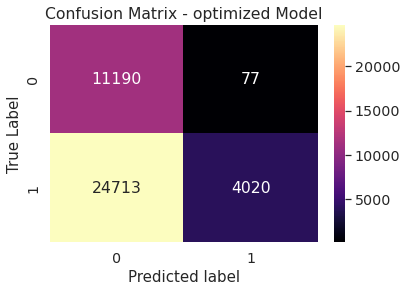

<Figure size 720x504 with 0 Axes>

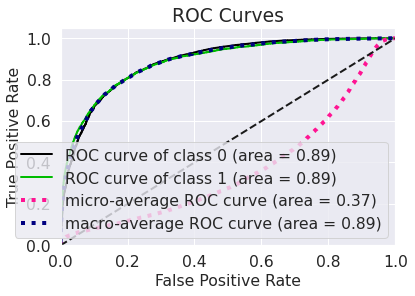

<Figure size 3240x2304 with 0 Axes>

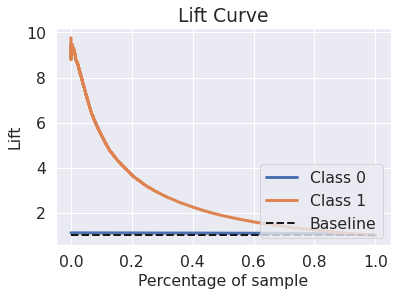

In [ ]:
# Calculating the confusion matrix, accuracy, error, f-score, recall, precision
y_pred = clf.predict(x_val)
confusion_matrix = metrics.confusion_matrix(y_pred,y_val)
#turn this into a dataframe
matrix_df = pd.DataFrame(confusion_matrix)

#plot the result
ax = plt.axes()
sns.set(font_scale=1.3)
plt.figure(figsize=(10,7))
sns.heatmap(matrix_df, annot=True, fmt="g", ax=ax, cmap="magma")
#set axis titles
ax.set_title('Confusion Matrix - optimized Model')
ax.set_xlabel("Predicted label", fontsize =15)

ax.set_ylabel("True Label", fontsize=15)
plt.show()

# Implementing ROC Curves
y_probas = clf.predict_proba(x_val)
import scikitplot as skplt
skplt.metrics.plot_roc(y_val,y_probas)
plt.figure(figsize=(45, 32))
plt.show()

# Implementing Lift Curves
skplt.metrics.plot_lift_curve(y_val,y_probas)
plt.show()

In [ ]:
matrix = classification_report(y_pred,y_val)
print('Classification report of test data on unoptimized Model: \n',matrix)


Classification report of test data on unoptimized Model: 
               precision    recall  f1-score   support

           0       0.31      0.99      0.47     11267
           1       0.98      0.14      0.24     28733

    accuracy                           0.38     40000
   macro avg       0.65      0.57      0.36     40000
weighted avg       0.79      0.38      0.31     40000



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


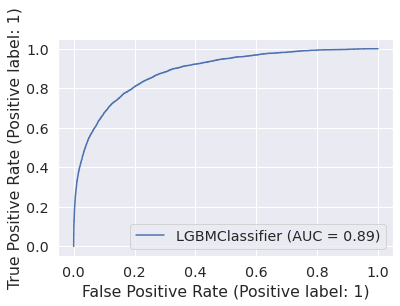

In [ ]:
metrics.plot_roc_curve(clf, x_val, y_val)
plt.show()

In [ ]:
y_pred = clf.predict_proba (x_val)

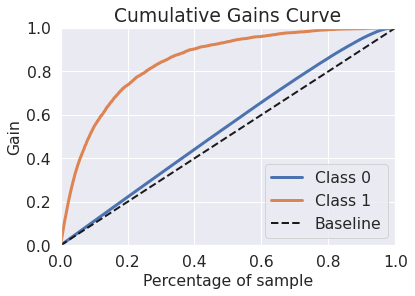

In [ ]:
skplt.metrics.plot_cumulative_gain(y_val, y_pred)




```
# This is formatted as code
```

### Creating a submission 


In [ ]:
# Test Data Prepearation

test_names = test_data['ID_code']
test_values = test_data.drop('ID_code',axis = 1)
test_values = transform(test_values,training_data)
test_columns = test_values.columns

# Scaling the values
#test_values = pd.DataFrame(robust_scaler.fit_transform(test_values), columns = test_columns)

# Predicting the test values

# Conversion to kaggle submission format
submission = pd.DataFrame({'ID_code':test_names,'target':logit_pred})
submission.to_csv('Submission_Bay_opt_lgbm.csv', index = False)
from google.colab import files
files.download('Submission_Bay_opt_lgbm.csv')

#

### https://www.kaggle.com/c/santander-customer-transaction-prediction/discussion/81289
### https://www.kaggle.com/code/dott1718/922-in-3-minutes/notebook